# IMPORTS

In [13]:
import pandas as pd
import seaborn as sns
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
from statsbombpy import sb
from pandas import json_normalize
import numpy as np
import requests
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde
import matplotlib.ticker as ticker
from scipy.optimize import differential_evolution

# DATA COLLECTION CODE

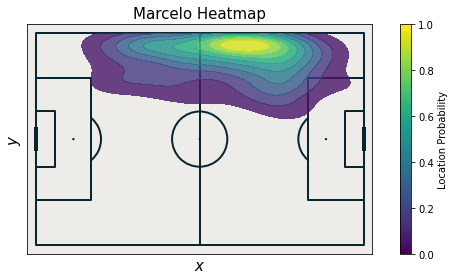

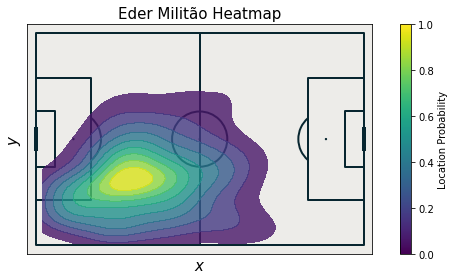

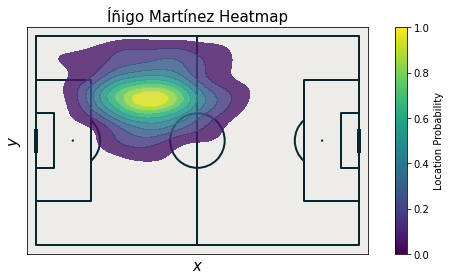

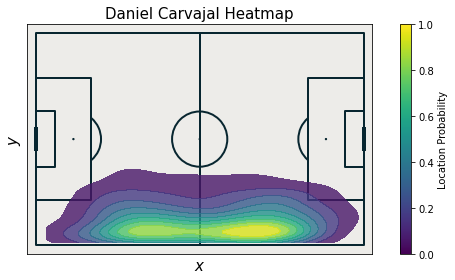

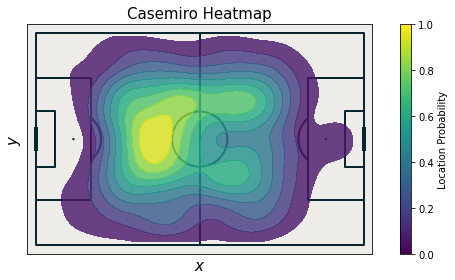

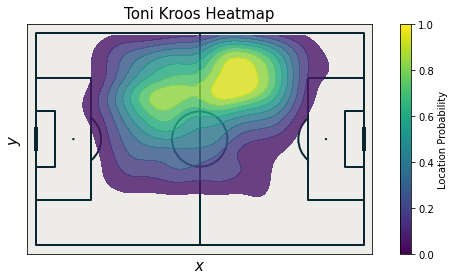

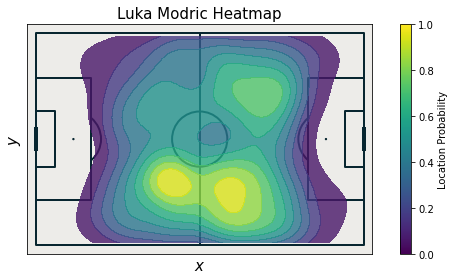

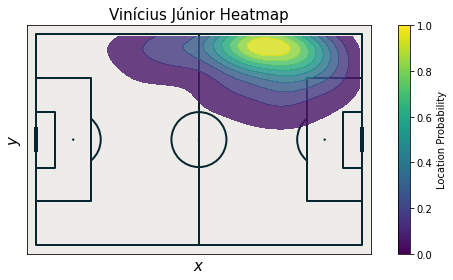

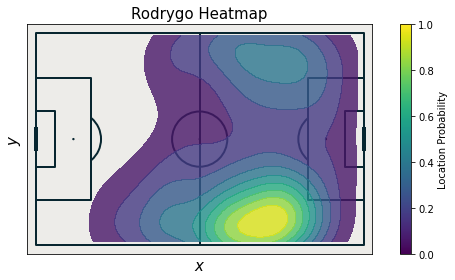

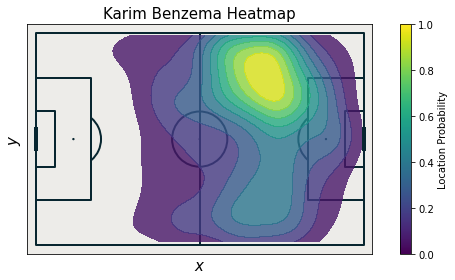

In [41]:
# Read data
data = pd.read_csv("WalkthroughLaLiga.csv")

# Create an empty dictionary to store probabilities for each player
player_probs = {}

# Define the player names
Real_Madrid = [
    "Marcelo",
    "Eder Militão",
    "Íñigo Martínez",
    "Daniel Carvajal",
    "Casemiro",
    "Toni Kroos",
    "Luka Modric",
    "Vinícius Júnior",
    "Rodrygo",
    "Karim Benzema"
]

# Create pitch object with 120 x 80 dimensions
pitch = Pitch(pitch_type='opta', pitch_color='#edece9', axis=True, label=False, line_color='#082630', tick=False)

# Initialize a 3D array to store probabilities for each player (10 players x 120 x 80)
probability_matrix = np.zeros((len(Real_Madrid), 120, 80))

# Plot KDE heat maps and contour plots for selected players
for i, player in enumerate(Real_Madrid):
    # Filter dataframe to only include passes received by the selected player
    player_data = data[data['receiver'] == player]
    
    # Calculate KDE
    kde = gaussian_kde(np.vstack([player_data.end_x, player_data.end_y]))
    
    # Evaluate KDE probabilities at each x, y coordinate
    x_grid, y_grid = np.mgrid[
        min(player_data.end_x):max(player_data.end_x):120j,
        min(player_data.end_y):max(player_data.end_y):80j
    ]
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    prob = kde(positions).reshape(x_grid.shape)
    prob = prob / np.max(prob)  # normalize
    
    # Store probability matrix in the 3D array
    probability_matrix[i] = prob
    
    # Plot KDE heat map
    fig, ax = pitch.draw(figsize=(8, 4))
    
    # Overlay contour plot directly on the pitch
    ax.contourf(x_grid, y_grid, prob, cmap='viridis', alpha=.8, locator=ticker.MaxNLocator(prune='lower'))
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis')
    sm.set_array([])  # Set dummy array to ensure the colorbar knows the range of values
    colorbar = plt.colorbar(sm, ax=ax)
    colorbar.set_label('Location Probability')

    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title(f'{player} Heatmap', fontsize=15)
    
    plt.show()

# OPTIMIZED WITH NO CONSTRAINTS (CONTROL GROUP)

Optimized position for Marcelo: [77.08007419 74.2795966 ]
Optimized position for Eder Militão: [32.59336351 22.36780864]
Optimized position for Íñigo Martínez: [42.11857101 56.53408659]
Optimized position for Daniel Carvajal: [38.51554397  5.39370449]
Optimized position for Casemiro: [43.93310845 40.83103599]
Optimized position for Toni Kroos: [72.35984819 61.78770632]
Optimized position for Luka Modric: [52.358706  24.4669034]
Optimized position for Vinícius Júnior: [83.10306474 75.97612709]
Optimized position for Rodrygo: [81.27565034  7.03261682]
Optimized position for Karim Benzema: [82.76833398 64.45840016]


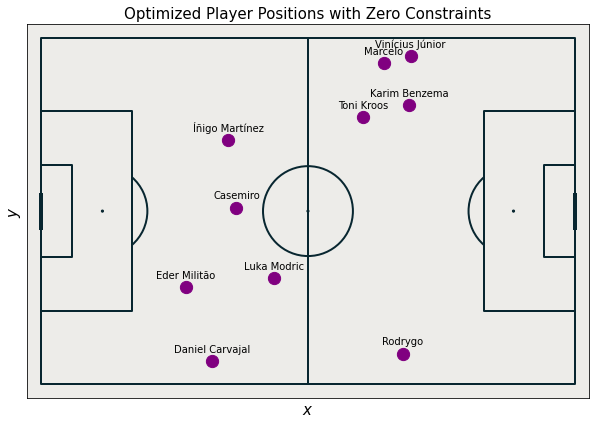

In [79]:
iteration_count = 0

# Callback function to track optimization iterations
def iteration_callback(xk, convergence):
    global iteration_count
    iteration_count += 1

team_weight = 0.7  # Adjust this value between 0 and 1 to balance individual and team probabilities

# Objective function to minimize
def objective(x, probability_matrix, player_idx):
    # x is a 2-element array with [x_coordinate, y_coordinate]
    x_idx = int(np.clip(x[0], 0, 119))
    y_idx = int(np.clip(x[1], 0, 79))

    # Avoid division by zero by adding a small constant
    probability_penalty = 1 / (probability_matrix[player_idx, x_idx, y_idx] + 1e-10)

    # Calculate the sum of individual player probabilities
    team_probability = 0
    for i in range(len(Real_Madrid)):
        team_probability += 1 / (probability_matrix[i, int(optimized_positions[i, 0]), int(optimized_positions[i, 1])] + 1e-10)

    # Combine individual player probability, clustering penalty, and team probability
    objective_value = (1 - team_weight) * probability_penalty + team_weight * team_probability

    return objective_value

# Optimization function for a single player
def optimize_player(player_idx):
    bounds = [(0, 119), (0, 79)]  # Bounds for x and y coordinates
    result = differential_evolution(objective, bounds, args=(probability_matrix, player_idx), strategy='best1bin',
                                   popsize=15, tol=1e-4, mutation=(0.5, 1), recombination=0.7,
                                   seed=42, callback=iteration_callback)
    return result.x

# Optimize positions for all players
optimized_positions = np.zeros((len(Real_Madrid), 2))

for i, player in enumerate(Real_Madrid):
    optimized_positions[i] = optimize_player(i)
    print(f"Optimized position for {player}: {optimized_positions[i]}")

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

# Plot the optimized positions and save the figure
fig, ax = pitch.draw(figsize=(10, 6))  

# Plot each player's optimized position
for i, player in enumerate(Real_Madrid):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, label='_nolegend_')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Optimized Player Positions with Zero Constraints', fontsize=15)

# Save the figure
plt.savefig("optimized_positions_with_names.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# OPTIMIZED WHILE PREVENTING CLUSTERS

Optimized position for Marcelo: [77.08007419 74.2795966 ]
Optimized position for Eder Militão: [32.59336351 22.36780864]
Optimized position for Íñigo Martínez: [42.11857101 56.53408659]
Optimized position for Daniel Carvajal: [78.63771254  5.58040282]
Optimized position for Casemiro: [69.79676507 54.01132239]
Optimized position for Toni Kroos: [53.98974536 39.16106631]
Optimized position for Luka Modric: [69.70914523 24.63402394]
Optimized position for Vinícius Júnior: [97.99999843 75.1009292 ]
Optimized position for Rodrygo: [97.99768338 13.77356928]
Optimized position for Karim Benzema: [90.99517901 54.50483716]


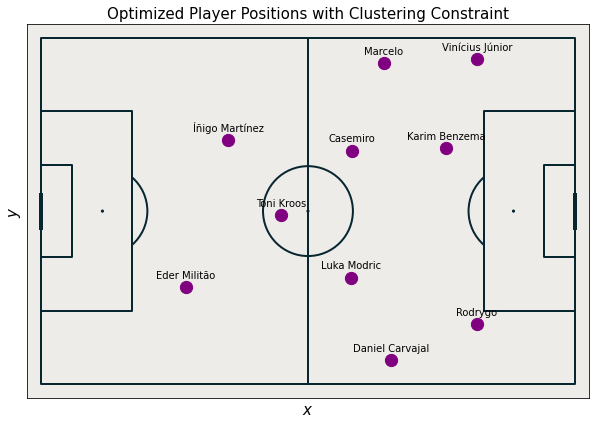

In [81]:
iteration_count = 0

# Callback function to track optimization iterations
def iteration_callback(xk, convergence):
    global iteration_count
    iteration_count += 1

# Define the minimum distance threshold and team weight
min_distance = 21  # Minimum desired distance between players (adjust as needed)
team_weight = 0.7  # Adjust this value between 0 and 1 to balance individual and team probabilities

# Objective function to minimize
def objective(x, probability_matrix, player_idx):
    # x is a 2-element array with [x_coordinate, y_coordinate]
    x_idx = int(np.clip(x[0], 0, 119))
    y_idx = int(np.clip(x[1], 0, 79))

    # Avoid division by zero by adding a small constant
    probability_penalty = 1 / (probability_matrix[player_idx, x_idx, y_idx] + 1e-10)

    # Initialize clustering penalty
    clustering_penalty = 0

    # Calculate distance between the current player and all other players
    for other_idx, other_position in enumerate(optimized_positions):
        if other_idx != player_idx:
            distance = np.linalg.norm(x - other_position)
            if distance < min_distance:
                clustering_penalty += (min_distance - distance) ** 2

    # Calculate the sum of individual player probabilities
    team_probability = 0
    for i in range(len(Real_Madrid)):
        team_probability += 1 / (probability_matrix[i, int(optimized_positions[i, 0]), int(optimized_positions[i, 1])] + 1e-10)

    # Combine individual player probability, clustering penalty, and team probability
    objective_value = (1 - team_weight) * probability_penalty + team_weight * team_probability + clustering_penalty

    return objective_value

# Optimization function for a single player
def optimize_player(player_idx):
    bounds = [(0, 119), (0, 79)]  # Bounds for x and y coordinates
    result = differential_evolution(objective, bounds, args=(probability_matrix, player_idx), strategy='best1bin',
                                    popsize=15, tol=1e-4, mutation=(0.5, 1), recombination=0.7,
                                    seed=42, callback=iteration_callback)
    return result.x

# Optimize positions for all players
optimized_positions = np.zeros((len(Real_Madrid), 2))
for i, player in enumerate(Real_Madrid):
    optimized_positions[i] = optimize_player(i)
    print(f"Optimized position for {player}: {optimized_positions[i]}")

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

# Plot the optimized positions and save the figure
fig, ax = pitch.draw(figsize=(10, 6))

# Plot each player's optimized position
for i, player in enumerate(Real_Madrid):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, label='_nolegend_')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Optimized Player Positions with Clustering Constraint', fontsize=15)

# Save the figure
plt.savefig("optimized_positions_with_names.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# ADDING OPPOSING TEAM